# Oracle 

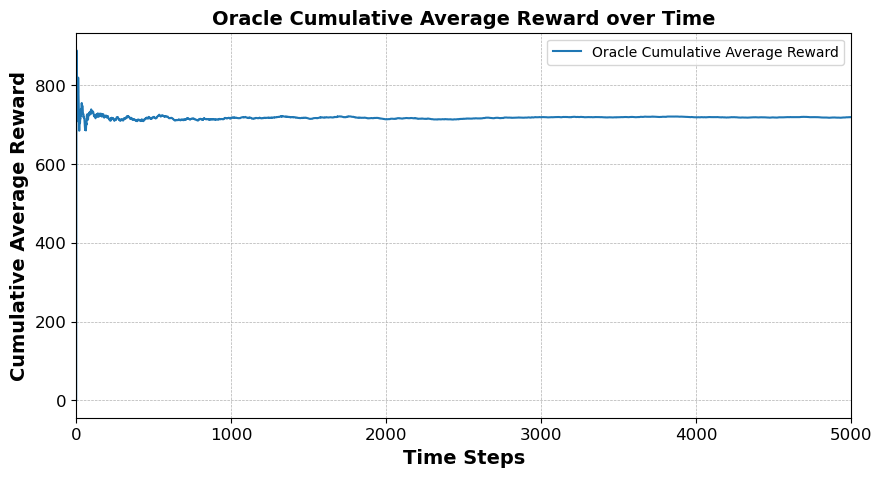

In [421]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pivot_df = pd.read_csv('simulated_sensor_data.csv')
#pivot_df = pd.read_csv('synthetic_dataset.csv')
#pivot_df = pd.read_csv('synthetic_dataset_two.csv')
#pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
#pivot_df = pd.read_csv('top_fifty_motes_humidity.csv')
#pivot_df = pivot_df.head(10000)

# Parameters
num_nodes_to_poll_list = [10]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled 
theta = 0.5                           # Threshold for significant change
alpha = 15    # Set your desired alpha value
beta = 5   # Set your desired beta value

# Initialize last polled values with an assumed initial estimate of 20
last_polled_values = {f'mote{i}': 20 for i in range(1, 51)}

def run_oracle_simulation(num_nodes_to_poll):
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    cumulative_reward = []
    valuable_sensor_data = []

    for idx in range(len(pivot_df)):  # Loop over each time step
        current_time_step = idx
        rewards = {}

        for mote in last_update_times:
            delta_t = (current_time_step - last_update_times[mote])
            if delta_t > 0:
                current_value = pivot_df.loc[current_time_step, mote]
                last_value = last_polled_values[mote]  # Retrieve the last polled value (initially set to 20)

                # Calculate magnitude change and AoII
                magnitude_change = abs(current_value - last_value) * alpha
                weighted_time =   beta/delta_t
                AoII = magnitude_change * weighted_time
                rewards[mote] = AoII

        # Sort nodes by AoII and select top M nodes with rewards greater than theta
        top_m_nodes = [mote for mote in sorted(rewards, key=rewards.get, reverse=True) if rewards[mote] > theta][:num_nodes_to_poll]
        #top_m_nodes = sorted(rewards, key=rewards.get, reverse=True)[:num_nodes_to_poll]
        total_reward_for_round = 0

        for mote in top_m_nodes:
            measured_value = pivot_df.loc[current_time_step, mote]
            delta_t = (current_time_step - last_update_times[mote])

            # Recalculate AoII for the selected nodes
            magnitude_change = abs(measured_value - last_polled_values[mote]) * alpha
            weighted_time =   beta/delta_t
            AoII = magnitude_change * weighted_time

            if np.isnan(AoII):
                AoII = 0  # Replace NaN rewards with zero
            if abs(measured_value - last_polled_values[mote]) > theta:
                total_reward_for_round += (AoII-2)
            else:
                total_reward_for_round -= 2 # Penalty for unnecessary polling

            # Update last polled value and time
            last_update_times[mote] = current_time_step
            last_polled_values[mote] = measured_value  # Update with the new polled value

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': measured_value,  # Oracle knows the true value
                'time_elapsed': delta_t
            })

        cumulative_reward.append(total_reward_for_round)

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    return cumulative_reward, valuable_sensor_df

results_oracle = {}
cumulative_rewards_oracle = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    cumulative_reward, valuable_sensor_df = run_oracle_simulation(num_nodes_to_poll)
    cumulative_rewards_oracle.append(cumulative_reward)

# Save cumulative rewards for Oracle to CSV
pd.DataFrame(cumulative_rewards_oracle[0], columns=["cumulative_reward"]).to_csv('cumulative_rewards_oracle.csv', index=False)

# Calculate cumulative reward and cumulative average reward for Oracle
cumulative_reward_array_oracle = np.cumsum(cumulative_rewards_oracle[0])
cumulative_average_reward_oracle = cumulative_reward_array_oracle / (np.arange(len(cumulative_reward_array_oracle)) + 1)

# Check for NaN or inf values
nan_indices = np.where(np.isnan(cumulative_reward_array_oracle))[0]
inf_indices = np.where(np.isinf(cumulative_reward_array_oracle))[0]

# Plot cumulative average reward over time for Oracle
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward_oracle)), cumulative_average_reward_oracle, label='Oracle Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=14, fontweight='bold')
plt.title('Oracle Cumulative Average Reward over Time', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, len(pivot_df))  # Force x-axis to cover the entire length of the dataset

# Save the plot
plt.savefig('oracle_cumulative_average_reward.png')

plt.show()


# Restructuring the reward

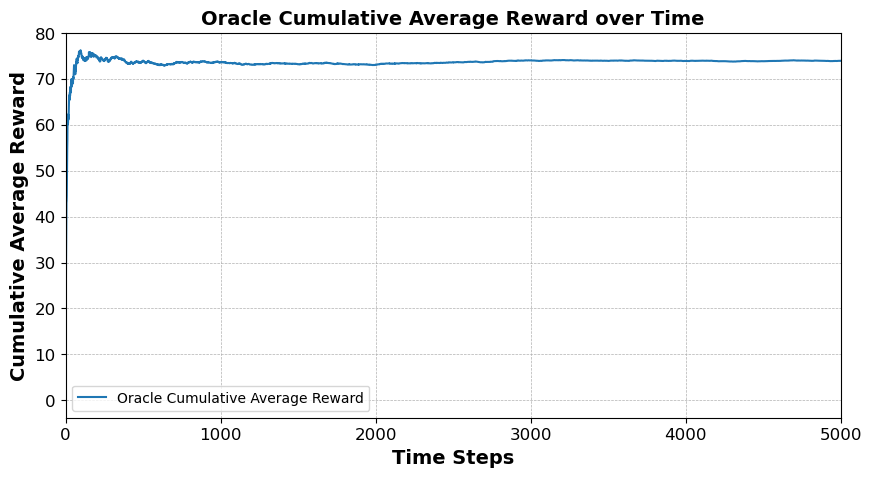

: 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pivot_df = pd.read_csv('simulated_sensor_data.csv')
#pivot_df = pd.read_csv('synthetic_dataset.csv')
#pivot_df = pd.read_csv('synthetic_dataset_two.csv')
#pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
#pivot_df = pd.read_csv('top_fifty_motes_humidity.csv')
#pivot_df = pivot_df.head(10000)

# Parameters
num_nodes_to_poll_list = [10]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled 
theta = 0.5                           # Threshold for significant change
alpha = 15    # Set your desired alpha value
beta = 5   # Set your desired beta value

# Initialize last polled values with an assumed initial estimate of 20
last_polled_values = {f'mote{i}': 20 for i in range(1, 51)}

def run_oracle_simulation(num_nodes_to_poll):
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    cumulative_reward = []
    valuable_sensor_data = []

    for idx in range(len(pivot_df)):  # Loop over each time step
        current_time_step = idx
        rewards = {}

        for mote in last_update_times:
            delta_t = (current_time_step - last_update_times[mote])
            if delta_t > 0:
                current_value = pivot_df.loc[current_time_step, mote]
                last_value = last_polled_values[mote]  # Retrieve the last polled value (initially set to 20)

                # Calculate magnitude change and AoII
                magnitude_change = abs(current_value - last_value) * alpha
                weighted_time =  delta_t/beta
                AoII = magnitude_change * weighted_time
                rewards[mote] = AoII

        # Sort nodes by AoII and select top M nodes with rewards greater than theta
        top_m_nodes = [mote for mote in sorted(rewards, key=rewards.get, reverse=True) if rewards[mote] > theta][:num_nodes_to_poll]
        #top_m_nodes = sorted(rewards, key=rewards.get, reverse=True)[:num_nodes_to_poll]
        total_reward_for_round = 0

        for mote in top_m_nodes:
            measured_value = pivot_df.loc[current_time_step, mote]
            delta_t = (current_time_step - last_update_times[mote])

            # Recalculate AoII for the selected nodes
            magnitude_change = abs(measured_value - last_polled_values[mote]) * alpha
            weighted_time =   delta_t/beta
            AoII = magnitude_change * weighted_time

            if np.isnan(AoII):
                AoII = 0  # Replace NaN rewards with zero
            if abs(measured_value - last_polled_values[mote]) > theta:
                total_reward_for_round += (AoII-2)
            else:
                total_reward_for_round -= 2 # Penalty for unnecessary polling

            # Update last polled value and time
            last_update_times[mote] = current_time_step
            last_polled_values[mote] = measured_value  # Update with the new polled value

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': measured_value,  # Oracle knows the true value
                'time_elapsed': delta_t
            })

        cumulative_reward.append(total_reward_for_round)

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    return cumulative_reward, valuable_sensor_df

results_oracle = {}
cumulative_rewards_oracle = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    cumulative_reward, valuable_sensor_df = run_oracle_simulation(num_nodes_to_poll)
    cumulative_rewards_oracle.append(cumulative_reward)

# Save cumulative rewards for Oracle to CSV
pd.DataFrame(cumulative_rewards_oracle[0], columns=["cumulative_reward"]).to_csv('cumulative_rewards_oracle.csv', index=False)

# Calculate cumulative reward and cumulative average reward for Oracle
cumulative_reward_array_oracle = np.cumsum(cumulative_rewards_oracle[0])
cumulative_average_reward_oracle = cumulative_reward_array_oracle / (np.arange(len(cumulative_reward_array_oracle)) + 1)

# Check for NaN or inf values
nan_indices = np.where(np.isnan(cumulative_reward_array_oracle))[0]
inf_indices = np.where(np.isinf(cumulative_reward_array_oracle))[0]

# Plot cumulative average reward over time for Oracle
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward_oracle)), cumulative_average_reward_oracle, label='Oracle Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=14, fontweight='bold')
plt.title('Oracle Cumulative Average Reward over Time', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, len(pivot_df))  # Force x-axis to cover the entire length of the dataset

# Save the plot
plt.savefig('oracle_cumulative_average_reward.png')

plt.show()


# Round Robin

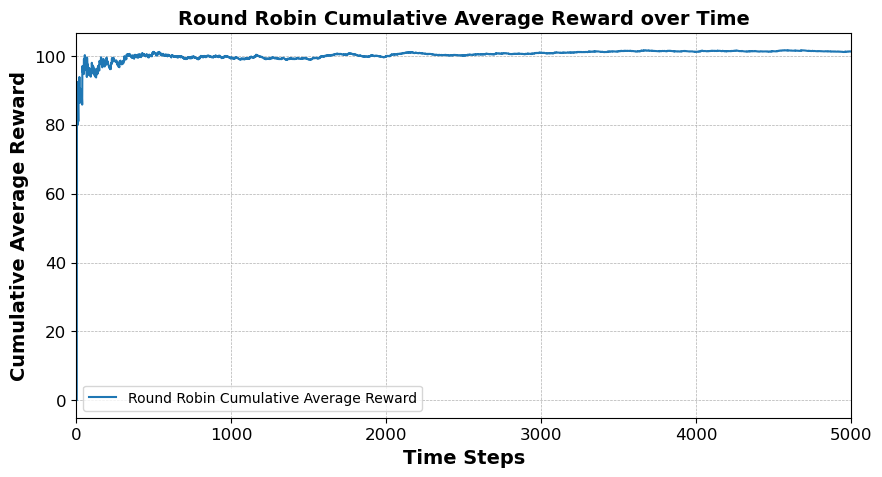

In [422]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


pivot_df = pd.read_csv('simulated_sensor_data.csv')
#pivot_df = pd.read_csv('synthetic_dataset.csv')
#pivot_df = pd.read_csv('synthetic_dataset_two.csv')
#pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
#pivot_df = pd.read_csv('top_fifty_motes_humidity.csv')
#pivot_df = pivot_df.head(10000)

alpha = 3  # Set your desired alpha value
beta = 1   # Set your desired beta value

# Extract the list of nodes (column names excluding the 'SN' column)
nodes = [col for col in pivot_df.columns if col != 'SN']
total_nodes = len(nodes)  # Total number of nodes
num_pulls_per_round = 10  # Number of nodes to pull in each round
interval = total_nodes // num_pulls_per_round  # Time interval between pulls of the same node
theta = 0.5  # Threshold for significant reward

# Initialize variables
last_measured_values = {node: None for node in nodes}
last_update_times = {node: -interval for node in nodes}
cumulative_reward = []
valuable_sensor_data = []

def run_round_robin_simulation():
    current_round = 0
    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        node_start = (current_round * num_pulls_per_round) % total_nodes
        nodes_to_poll = nodes[node_start:node_start + num_pulls_per_round]

        total_reward_for_round = 0
        for node in nodes_to_poll:
            measured_value = row[node]
            delta_t = (current_time_step - last_update_times[node])

            weighted_time =  beta/delta_t 

            if last_measured_values[node] is not None:
                
                magnitude_change = abs(measured_value - last_measured_values[node])*alpha
                AoII = magnitude_change * weighted_time
                if abs(measured_value - last_measured_values[node]) > theta:
                    total_reward_for_round += (AoII-2)

                else : 
                    total_reward_for_round -= 2

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_node': node,
                'temperature': measured_value,
                'time_elapsed': delta_t
            })

            last_update_times[node] = current_time_step
            last_measured_values[node] = measured_value

        cumulative_reward.append(total_reward_for_round)
        current_round += 1

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    return cumulative_reward, valuable_sensor_df

# Run the round-robin simulation and collect rewards
round_robin_rewards, valuable_sensor_df = run_round_robin_simulation()

# Save cumulative rewards for round-robin to CSV
pd.DataFrame(round_robin_rewards, columns=["cumulative_reward"]).to_csv('cumulative_rewards_round_robin.csv', index=False)

# Calculate cumulative reward and cumulative average reward for round-robin
cumulative_reward_array = np.cumsum(round_robin_rewards)
cumulative_average_reward = cumulative_reward_array / (np.arange(len(cumulative_reward_array)) + 1)

# Plot cumulative average reward over time
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward)), cumulative_average_reward, label='Round Robin Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=14, fontweight='bold')
plt.title('Round Robin Cumulative Average Reward over Time', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, len(pivot_df))  # Force x-axis to cover the entire length of the dataset

# Save the plot
plt.savefig('round_robin_cumulative_average_reward.png')

plt.show()


# UCB technique 

Running UCB simulation for 10 nodes to poll...
Completed UCB simulation for 10 nodes to poll.


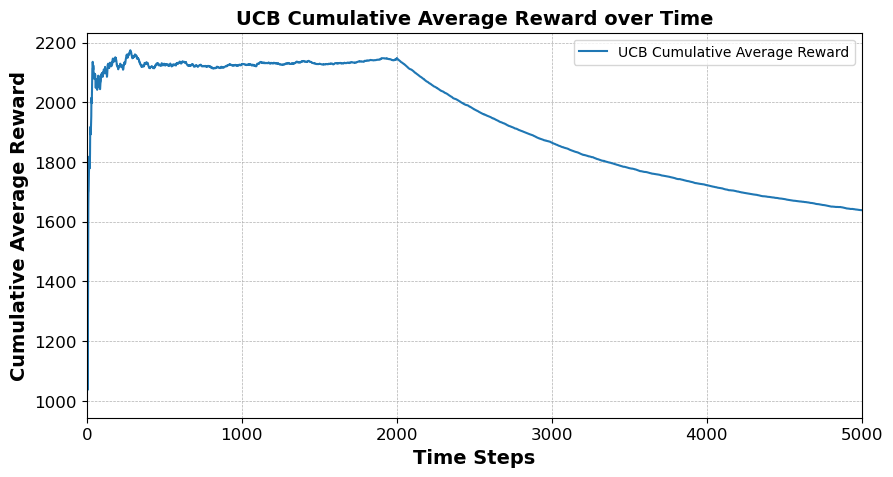

Running UCB simulation for 10 nodes to poll...
Completed UCB simulation for 10 nodes to poll.


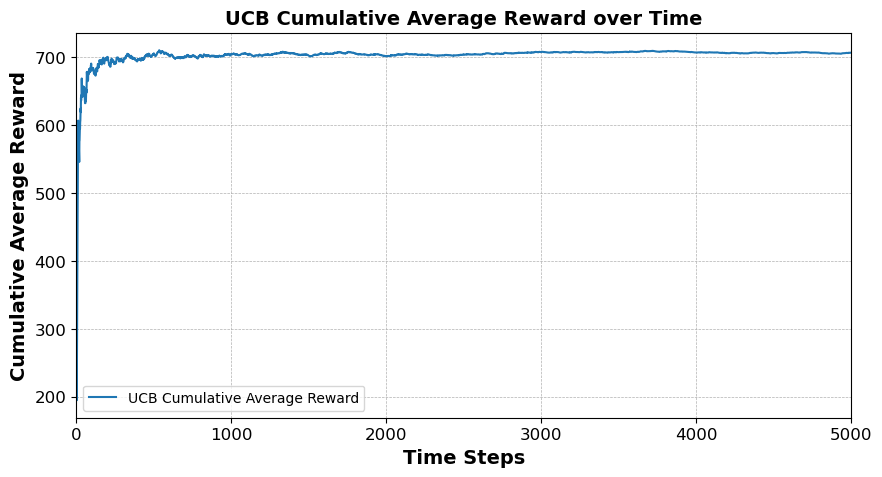

In [423]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

pivot_df = pd.read_csv('simulated_sensor_data.csv')
#pivot_df = pd.read_csv('synthetic_dataset.csv')
#pivot_df = pd.read_csv('synthetic_dataset_two.csv')
#pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
#pivot_df = pd.read_csv('top_fifty_motes_humidity.csv')
#pivot_df = pivot_df.head(10000)

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance

theta = 0.5                            # Threshold for significant change (equal to m_i)
num_nodes_to_poll_list = [10]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# UCB parameters
alpha = 15  # Exploration parameter for UCB
beta = 5  

# BanditArm class
class BanditArm:
    def __init__(self, initial_value=0.):
        self.value_estimate = initial_value
        self.N = 0  # Number of samples collected so far

    def update(self, value):
        self.N += 1
        self.value_estimate = ((self.N - 1) * self.value_estimate + value) / self.N

def ucb(p_estimate, total_pulls, n):
    return p_estimate + np.sqrt(2 * np.log(total_pulls) / n) if n > 0 else float('inf')

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    bandit_arms = {f'mote{i}': BanditArm() for i in range(1, 51)}
    transmission_events_1 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1-1000
    transmission_events_2 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1000-2000
    previously_polled_nodes = set()  # Initialize previously_polled_nodes
    cumulative_reward = []

    def predict_node_state(x_hat, delta_t):
        A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
        return A_delta @ x_hat

    def select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes):
        total_pulls = sum(polled_count.values())
        expected_rewards = {mote: 0 for mote in state_estimates}  # Initialize expected rewards dictionary
        
        for mote in state_estimates:
            delta_t = current_time_step - last_update_times[mote]
            if delta_t > 0:
                predicted_state = predict_node_state(state_estimates[mote], delta_t)
                predicted_value = H @ predicted_state
                current_value = last_sensed_values[mote]
                E_R_s =  ( beta/delta_t  ) * (abs(predicted_value - current_value))* alpha
                #E_R_s = - abs(predicted_value - current_value)  # Change expected reward calculation

                if np.isnan(E_R_s):
                    E_R_s = 0  # Replace NaN expected rewards with zero
                expected_rewards[mote] = E_R_s
        
        # Update value estimates for all nodes
        for mote in expected_rewards:
            bandit_arms[mote].update(expected_rewards[mote])

        ucb_values = {
            mote: ucb(bandit_arms[mote].value_estimate, total_pulls, polled_count[mote])
            for mote in state_estimates
        }
        # Select top M nodes based on UCB scores
        nodes_by_ucb = sorted(ucb_values.keys(), key=lambda mote: ucb_values[mote], reverse=True)
        #top_m_nodes = nodes_by_ucb[:num_nodes_to_poll]
        nodes_to_poll = nodes_by_ucb[:num_nodes_to_poll]

        # Filter the top M nodes based on the prediction threshold
        """nodes_to_poll = []
        for mote in top_m_nodes:
            if expected_rewards[mote] > theta:
                nodes_to_poll.append(mote)
        """
        
        return nodes_to_poll

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        nodes_to_poll = select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes)
        #nodes_to_poll = list(currently_polled_nodes) + nodes_to_poll
        #nodes_to_poll =  nodes_to_poll

        total_reward_for_round = 0
        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat
            magnitude = abs(last_sensed_values[mote] - measured_value) * alpha
            A_R_s =  (beta/delta_t) * magnitude  # Calculate the actual reward
            if np.isnan(A_R_s):
                A_R_s = 0  # Replace NaN actual rewards with zero
            if abs(last_sensed_values[mote] - measured_value)> theta:  # Add reward only if it exceeds the threshold
                total_reward_for_round += (A_R_s-2)

            else :

                total_reward_for_round -= 2

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'Temperature': measured_value,
                'predicted temperature': x_hat[0, 0],
                'time_elapsed': delta_t
            })



        cumulative_reward.append(total_reward_for_round)
        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step
            last_sensed_values[mote] = row[mote]

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    valuable_sensor_df['squared_error'] = (valuable_sensor_df['Temperature'] - valuable_sensor_df['predicted temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    return average_mse, cumulative_reward, valuable_sensor_df, transmission_events_1, transmission_events_2

results = {}
valuable_sensor_df_list = []
transmission_events_1_list = []
transmission_events_2_list = []
cumulative_rewards_ucb = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running UCB simulation for {num_nodes_to_poll} nodes to poll...")
    mse, cumulative_reward, valuable_sensor_df, transmission_events_1, transmission_events_2 = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse}
    cumulative_rewards_ucb.append(cumulative_reward)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    transmission_events_1_list.append(transmission_events_1)
    transmission_events_2_list.append(transmission_events_2)
    print(f"Completed UCB simulation for {num_nodes_to_poll} nodes to poll.")

# Save cumulative rewards for UCB to CSV
pd.DataFrame(cumulative_rewards_ucb[0], columns=["cumulative_reward"]).to_csv('cumulative_rewards_ucb.csv', index=False)

# Calculate cumulative reward and cumulative average reward for UCB
cumulative_reward_array_ucb = np.cumsum(cumulative_rewards_ucb[0])
cumulative_average_reward_ucb = cumulative_reward_array_ucb / (np.arange(len(cumulative_reward_array_ucb)) + 1)

# Plot cumulative average reward over time for UCB
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward_ucb)), cumulative_average_reward_ucb, label='UCB Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=14, fontweight='bold')
plt.title('UCB Cumulative Average Reward over Time', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, len(pivot_df))  # Force x-axis to cover the entire length of the dataset
plt.show()


# Kalman pooling technique 

Running simulation for 10 nodes to poll...
Completed simulation for 10 nodes to poll.
Nodes to poll: 10
  Average MSE: 31.13780534959701
  Average sensor lifetime (years): 4.128526924728623


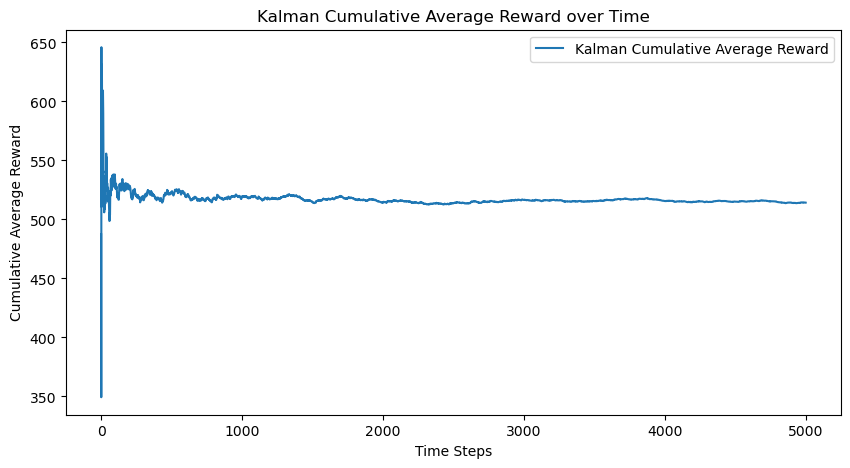

In [424]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pivot_df = pd.read_csv('simulated_sensor_data.csv')
#pivot_df = pd.read_csv('synthetic_dataset.csv')
#pivot_df = pd.read_csv('synthetic_dataset_two.csv')
#pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
#pivot_df = pd.read_csv('top_fifty_motes_humidity.csv')
#pivot_df = pivot_df.head(10000)

alpha = 15  # Set your desired alpha value
beta = 5  # Set your desired beta value

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance

theta = 0.5                           # Threshold for significant change
num_nodes_to_poll_list = [10]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    cumulative_reward = []

    def predict_node_state(x_hat, delta_t):
        A = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix
        return A @ x_hat

    def select_top_nodes(state_estimates, P, num_nodes_to_poll, currently_polled_nodes):
        covariance_traces = {mote: np.trace(P[mote]) for mote in state_estimates}
        sorted_motes_by_trace = sorted(covariance_traces, key=covariance_traces.get, reverse=True)
        top_nodes = set(sorted_motes_by_trace[:num_nodes_to_poll])
        return top_nodes 
        #return top_nodes | currently_polled_nodes 

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        top_sensors = select_top_nodes(state_estimates, P, num_nodes_to_poll, currently_polled_nodes)

        total_reward_for_round = 0
        for mote in top_sensors:
            polled_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            
            A = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix
            xp = A @ previous_state
            Pp = A @ previous_P @ A.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            # Corrected section
            last_value = last_sensed_values[mote]
            diff = abs(measured_value - last_value)*alpha
            weighted_time =  beta/delta_t
            R_s = diff* weighted_time

            if abs(measured_value - last_value) > theta:  # Add reward only if it exceeds the threshold
                total_reward_for_round += (R_s-2)
                transmitted_count[mote] += 1
                last_sensed_values[mote] = measured_value

                valuable_sensor_data.append({
                    'index': current_time_step,
                    'selected_moteid': mote,
                    'temperature': measured_value,
                    'predicted_temperature': x_hat[0, 0],  # Still keep the predicted temperature for analysis
                    'time_elapsed': delta_t
                })
            else :
                total_reward_for_round -= 2

            currently_polled_nodes.add(mote)
            last_update_times[mote] = current_time_step

        cumulative_reward.append(total_reward_for_round)

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, average_lifetime_years, cumulative_reward

results = {}
valuable_sensor_df_list = []
cumulative_rewards_kalman = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime, cumulative_reward = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    cumulative_rewards_kalman.append(cumulative_reward)
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")

# Save cumulative rewards for Kalman to CSV
pd.DataFrame(cumulative_rewards_kalman[0], columns=["cumulative_reward"]).to_csv('cumulative_rewards_kalman.csv', index=False)

# Calculate cumulative reward and cumulative average reward for Kalman
cumulative_reward_array_kalman = np.cumsum(cumulative_rewards_kalman[0])
cumulative_average_reward_kalman = cumulative_reward_array_kalman / (np.arange(len(cumulative_reward_array_kalman)) + 1)

# Plot cumulative average reward over time for Kalman
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward_kalman)), cumulative_average_reward_kalman, label='Kalman Cumulative Average Reward')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Average Reward')
plt.title('Kalman Cumulative Average Reward over Time')
plt.legend()
plt.show()



# Whittle index based technique

# Exploring cummulative Q values 

Running Whittle simulation for 10 nodes to poll...
Completed Whittle simulation for 10 nodes to poll.


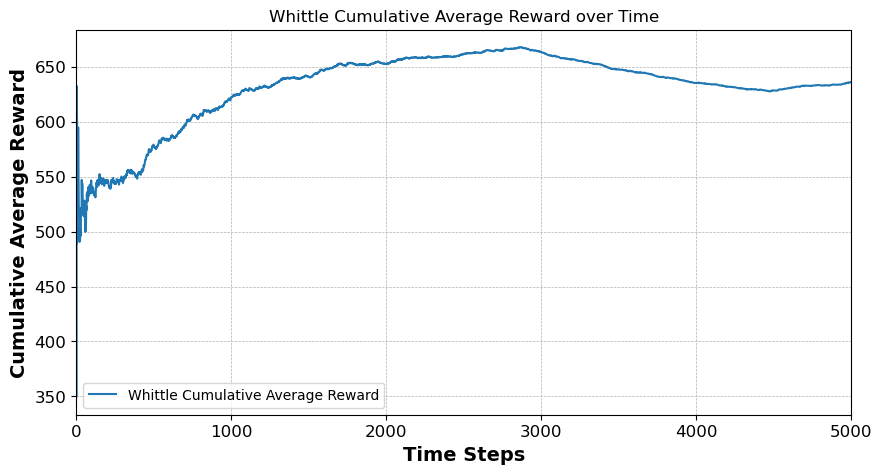

In [425]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

pivot_df = pd.read_csv('simulated_sensor_data.csv')
#pivot_df = pd.read_csv('synthetic_dataset.csv')
#pivot_df = pd.read_csv('synthetic_dataset_two.csv')
#pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
#pivot_df = pd.read_csv('top_fifty_motes_humidity.csv')
#pivot_df = pivot_df.head(10000)

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
theta = 0.5                           # Threshold for significant change (equal to m_i)
num_nodes_to_poll_list = [10]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
pdr = 0.9     
alpha = 15  # Set your desired alpha value
beta = 5                            # Probability of transmission failure

# WhittleArm class
class WhittleArm:
    def __init__(self, initial_value=0.):
        self.value_estimate = initial_value
        
    def update(self, value):
        
        self.value_estimate = value

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def calculate_q_value(mote, delta_t, predicted_value, current_value):
    """Calculate the Q-value for a given mote."""
    #return -theta  + ((delta_t) * abs(predicted_value - current_value)*2)
    return -2+(beta/delta_t) *  abs(predicted_value - current_value)*alpha

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    whittle_arms = {f'mote{i}': WhittleArm() for i in range(1, 51)}
    transmission_events_1 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1-1000
    transmission_events_2 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1000-2000
    previously_polled_nodes = set()
    cumulative_reward = []

    def predict_node_state(x_hat, delta_t):
        A_delta = get_state_transition_matrix(delta_t)
        return A_delta @ x_hat

    def select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes):
        expected_Q_value = {mote: 0 for mote in state_estimates}
        
        for mote in state_estimates:
            delta_t = (current_time_step - last_update_times[mote])
            if delta_t > 0:
                predicted_state = predict_node_state(state_estimates[mote], delta_t)
                predicted_value = H @ predicted_state
                current_value = last_sensed_values[mote]
                Q_value = calculate_q_value(mote, delta_t, predicted_value, current_value)
                if np.isnan(Q_value):
                    Q_value = 0
                expected_Q_value[mote] = Q_value
        
        for mote in expected_Q_value:
            whittle_arms[mote].update(expected_Q_value[mote])

        # Select top M nodes based on the highest value_estimate in whittle_arms
        nodes_by_whittle = sorted(whittle_arms.keys(), key=lambda mote: whittle_arms[mote].value_estimate, reverse=True)
        #top_m_nodes = nodes_by_whittle[:num_nodes_to_poll]
        nodes_to_poll = nodes_by_whittle[:num_nodes_to_poll]

        #nodes_to_poll = []
        """for mote in top_m_nodes:
            if expected_Q_value[mote] > theta:
                nodes_to_poll.append(mote)
        """
        
        return nodes_to_poll

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        nodes_to_poll = select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes)
        #nodes_to_poll = list(currently_polled_nodes) + nodes_to_poll

        total_reward_for_round = 0
        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat
            diff = abs(last_sensed_values[mote] - measured_value)*alpha
            A_R_s =  (beta/delta_t) * diff 
            if np.isnan(A_R_s):
                A_R_s = 0  # Replace NaN actual rewards with zero
            if abs(last_sensed_values[mote] - measured_value)  > theta:  # Add reward only if it exceeds the threshold
                total_reward_for_round += (A_R_s-2)
            else : 
                total_reward_for_round -= 2


            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'Temperature': measured_value,
                'predicted temperature': x_hat[0, 0],
                'time_elapsed': delta_t
            })

            if 0 <= current_time_step < 2000:
                transmission_events_1[mote].append(current_time_step)
            elif 2000 <= current_time_step < 5000:
                transmission_events_2[mote].append(current_time_step)

        cumulative_reward.append(total_reward_for_round)
        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step
            last_sensed_values[mote] = row[mote]

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    valuable_sensor_df['squared_error'] = (valuable_sensor_df['Temperature'] - valuable_sensor_df['predicted temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    return average_mse, cumulative_reward, valuable_sensor_df, transmission_events_1, transmission_events_2

results = {}
valuable_sensor_df_list = []
transmission_events_1_list = []
transmission_events_2_list = []
cumulative_rewards_whittle = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running Whittle simulation for {num_nodes_to_poll} nodes to poll...")
    mse, cumulative_reward, valuable_sensor_df, transmission_events_1, transmission_events_2 = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse}
    cumulative_rewards_whittle.append(cumulative_reward)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    transmission_events_1_list.append(transmission_events_1)
    transmission_events_2_list.append(transmission_events_2)
    print(f"Completed Whittle simulation for {num_nodes_to_poll} nodes to poll.")

# Save cumulative rewards for Whittle to CSV
pd.DataFrame(cumulative_rewards_whittle[0], columns=["cumulative_reward"]).to_csv('cumulative_rewards_whittle.csv', index=False)

# Calculate cumulative reward and cumulative average reward for Whittle
cumulative_reward_array_whittle = np.cumsum(cumulative_rewards_whittle[0])
cumulative_average_reward_whittle = cumulative_reward_array_whittle / (np.arange(len(cumulative_reward_array_whittle)) + 1)

# Plot cumulative average reward over time for Whittle
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward_whittle)), cumulative_average_reward_whittle, label='Whittle Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=14, fontweight='bold')
plt.title('Whittle Cumulative Average Reward over Time')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, len(pivot_df))  # Force x-axis to cover the entire length of the dataset
plt.show()



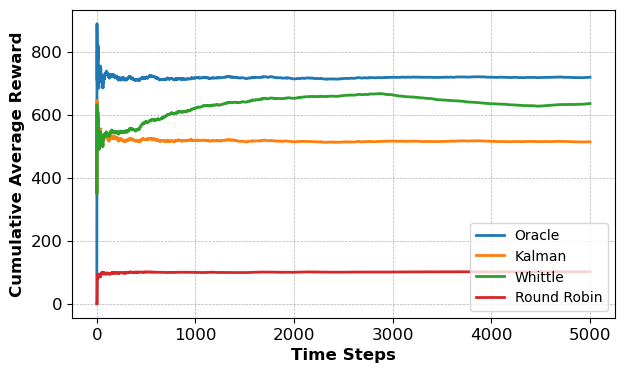

In [426]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load cumulative rewards from CSV files
cumulative_rewards_oracle = pd.read_csv('cumulative_rewards_oracle.csv')['cumulative_reward'].values
cumulative_rewards_ucb = pd.read_csv('cumulative_rewards_ucb.csv')['cumulative_reward'].values
cumulative_rewards_kalman = pd.read_csv('cumulative_rewards_kalman.csv')['cumulative_reward'].values
cumulative_rewards_whittle = pd.read_csv('cumulative_rewards_whittle.csv')['cumulative_reward'].values
cumulative_rewards_round_robin = pd.read_csv('cumulative_rewards_round_robin.csv')['cumulative_reward'].values

# Calculate cumulative average rewards
cumulative_average_reward_oracle = np.cumsum(cumulative_rewards_oracle) / (np.arange(len(cumulative_rewards_oracle)) + 1)
cumulative_average_reward_ucb = np.cumsum(cumulative_rewards_ucb) / (np.arange(len(cumulative_rewards_ucb)) + 1)
cumulative_average_reward_kalman = np.cumsum(cumulative_rewards_kalman) / (np.arange(len(cumulative_rewards_kalman)) + 1)
cumulative_average_reward_whittle = np.cumsum(cumulative_rewards_whittle) / (np.arange(len(cumulative_rewards_whittle)) + 1)
cumulative_average_reward_round_robin = np.cumsum(cumulative_rewards_round_robin) / (np.arange(len(cumulative_rewards_round_robin)) + 1)

# Plot cumulative average rewards over time for all techniques
# Plot cumulative average rewards over time for all techniques with M-limit from 0 to 1000
plt.figure(figsize=(7, 4))
plt.plot(range(len(cumulative_average_reward_oracle)), cumulative_average_reward_oracle, label='Oracle', linewidth=2)
#plt.plot(range(len(cumulative_average_reward_ucb)), cumulative_average_reward_ucb, label='UCB', linewidth=2)
plt.plot(range(len(cumulative_average_reward_kalman)), cumulative_average_reward_kalman, label='Kalman', linewidth=2)
plt.plot(range(len(cumulative_average_reward_whittle)), cumulative_average_reward_whittle, label='Whittle', linewidth=2)
plt.plot(range(len(cumulative_average_reward_round_robin)), cumulative_average_reward_round_robin, label='Round Robin', linewidth=2)
plt.xlabel('Time Steps', fontsize=12, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=12, fontweight='bold')
#plt.ylim(-50, 2000)  # Set the x-axis limit from 0 to 1000
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()




# Synthetic data 2

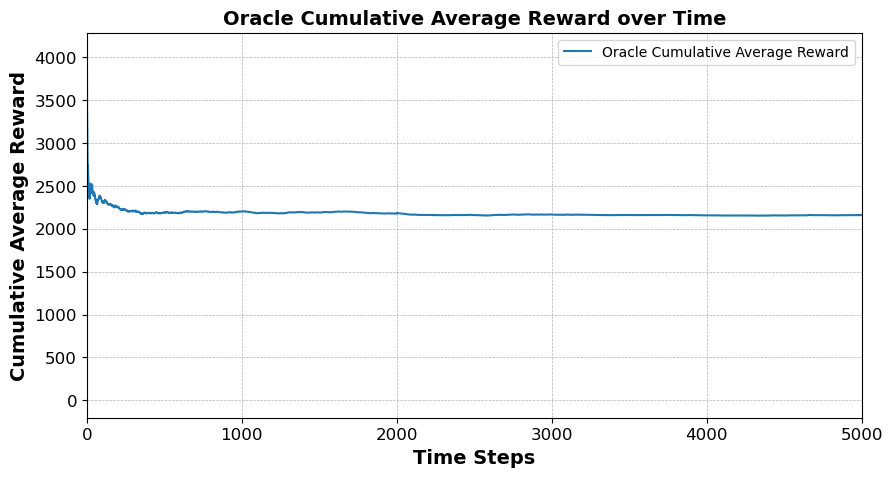

In [435]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#pivot_df = pd.read_csv('simulated_sensor_data.csv')
pivot_df = pd.read_csv('synthetic_dataset.csv')
#pivot_df = pd.read_csv('synthetic_dataset_two.csv')
#pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
#pivot_df = pd.read_csv('top_fifty_motes_humidity.csv')
#pivot_df = pivot_df.head(10000)

# Parameters
num_nodes_to_poll_list = [10]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled 
theta = 0.5                           # Threshold for significant change
alpha = 15    # Set your desired alpha value
beta = 5   # Set your desired beta value

# Initialize last polled values with an assumed initial estimate of 20
last_polled_values = {f'mote{i}': 20 for i in range(1, 51)}

def run_oracle_simulation(num_nodes_to_poll):
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    cumulative_reward = []
    valuable_sensor_data = []

    for idx in range(len(pivot_df)):  # Loop over each time step
        current_time_step = idx
        rewards = {}

        for mote in last_update_times:
            delta_t = (current_time_step - last_update_times[mote])
            if delta_t > 0:
                current_value = pivot_df.loc[current_time_step, mote]
                last_value = last_polled_values[mote]  # Retrieve the last polled value (initially set to 20)

                # Calculate magnitude change and AoII
                magnitude_change = abs(current_value - last_value) * alpha
                weighted_time =   beta/delta_t
                AoII = magnitude_change * weighted_time
                rewards[mote] = AoII

        # Sort nodes by AoII and select top M nodes with rewards greater than theta
        top_m_nodes = [mote for mote in sorted(rewards, key=rewards.get, reverse=True) if rewards[mote] > theta][:num_nodes_to_poll]
        #top_m_nodes = sorted(rewards, key=rewards.get, reverse=True)[:num_nodes_to_poll]
        total_reward_for_round = 0

        for mote in top_m_nodes:
            measured_value = pivot_df.loc[current_time_step, mote]
            delta_t = (current_time_step - last_update_times[mote])

            # Recalculate AoII for the selected nodes
            magnitude_change = abs(measured_value - last_polled_values[mote]) * alpha
            weighted_time =   beta/delta_t
            AoII = magnitude_change * weighted_time

            if np.isnan(AoII):
                AoII = 0  # Replace NaN rewards with zero
            if abs(measured_value - last_polled_values[mote]) > theta:
                total_reward_for_round += (AoII-2)
            else:
                total_reward_for_round -= 2 # Penalty for unnecessary polling

            # Update last polled value and time
            last_update_times[mote] = current_time_step
            last_polled_values[mote] = measured_value  # Update with the new polled value

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': measured_value,  # Oracle knows the true value
                'time_elapsed': delta_t
            })

        cumulative_reward.append(total_reward_for_round)

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    return cumulative_reward, valuable_sensor_df

results_oracle = {}
cumulative_rewards_oracle = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    cumulative_reward, valuable_sensor_df = run_oracle_simulation(num_nodes_to_poll)
    cumulative_rewards_oracle.append(cumulative_reward)

# Save cumulative rewards for Oracle to CSV
pd.DataFrame(cumulative_rewards_oracle[0], columns=["cumulative_reward"]).to_csv('cumulative_rewards_oracle.csv', index=False)

# Calculate cumulative reward and cumulative average reward for Oracle
cumulative_reward_array_oracle = np.cumsum(cumulative_rewards_oracle[0])
cumulative_average_reward_oracle = cumulative_reward_array_oracle / (np.arange(len(cumulative_reward_array_oracle)) + 1)

# Check for NaN or inf values
nan_indices = np.where(np.isnan(cumulative_reward_array_oracle))[0]
inf_indices = np.where(np.isinf(cumulative_reward_array_oracle))[0]

# Plot cumulative average reward over time for Oracle
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward_oracle)), cumulative_average_reward_oracle, label='Oracle Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=14, fontweight='bold')
plt.title('Oracle Cumulative Average Reward over Time', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, len(pivot_df))  # Force x-axis to cover the entire length of the dataset

# Save the plot
plt.savefig('oracle_cumulative_average_reward.png')

plt.show()


# Round Robin

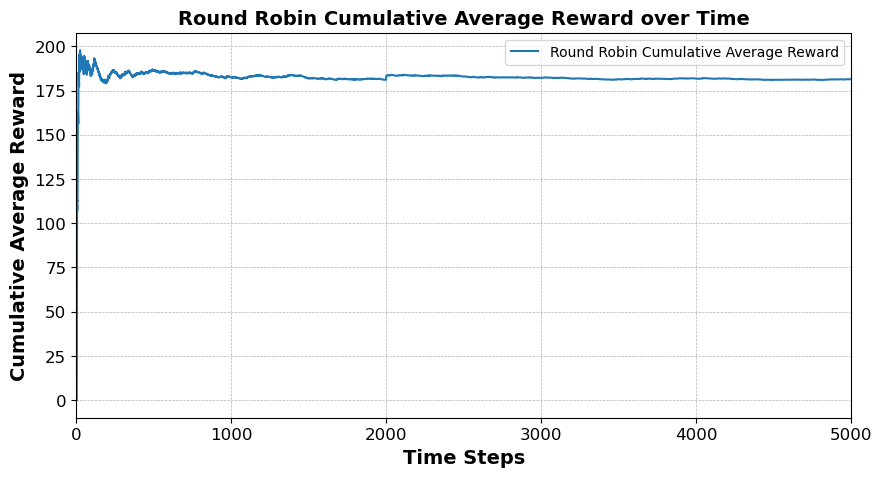

In [434]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#pivot_df = pd.read_csv('simulated_sensor_data.csv')
pivot_df = pd.read_csv('synthetic_dataset.csv')
#pivot_df = pd.read_csv('synthetic_dataset_two.csv')
#pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
#pivot_df = pd.read_csv('top_fifty_motes_humidity.csv')
#pivot_df = pivot_df.head(10000)

alpha = 15  # Set your desired alpha value
beta = 5   # Set your desired beta value

# Extract the list of nodes (column names excluding the 'SN' column)
nodes = [col for col in pivot_df.columns if col != 'SN']
total_nodes = len(nodes)  # Total number of nodes
num_pulls_per_round = 10  # Number of nodes to pull in each round
interval = total_nodes // num_pulls_per_round  # Time interval between pulls of the same node
theta = 0.5  # Threshold for significant reward

# Initialize variables
last_measured_values = {node: None for node in nodes}
last_update_times = {node: -interval for node in nodes}
cumulative_reward = []
valuable_sensor_data = []

def run_round_robin_simulation():
    current_round = 0
    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        node_start = (current_round * num_pulls_per_round) % total_nodes
        nodes_to_poll = nodes[node_start:node_start + num_pulls_per_round]

        total_reward_for_round = 0
        for node in nodes_to_poll:
            measured_value = row[node]
            delta_t = (current_time_step - last_update_times[node])

            weighted_time =  beta/delta_t 

            if last_measured_values[node] is not None:
                
                magnitude_change = abs(measured_value - last_measured_values[node])*alpha
                AoII = magnitude_change * weighted_time
                if abs(measured_value - last_measured_values[node]) > theta:
                    total_reward_for_round += (AoII-2)

                else : 
                    total_reward_for_round -= 2

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_node': node,
                'temperature': measured_value,
                'time_elapsed': delta_t
            })

            last_update_times[node] = current_time_step
            last_measured_values[node] = measured_value

        cumulative_reward.append(total_reward_for_round)
        current_round += 1

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    return cumulative_reward, valuable_sensor_df

# Run the round-robin simulation and collect rewards
round_robin_rewards, valuable_sensor_df = run_round_robin_simulation()

# Save cumulative rewards for round-robin to CSV
pd.DataFrame(round_robin_rewards, columns=["cumulative_reward"]).to_csv('cumulative_rewards_round_robin.csv', index=False)

# Calculate cumulative reward and cumulative average reward for round-robin
cumulative_reward_array = np.cumsum(round_robin_rewards)
cumulative_average_reward = cumulative_reward_array / (np.arange(len(cumulative_reward_array)) + 1)

# Plot cumulative average reward over time
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward)), cumulative_average_reward, label='Round Robin Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=14, fontweight='bold')
plt.title('Round Robin Cumulative Average Reward over Time', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, len(pivot_df))  # Force x-axis to cover the entire length of the dataset

# Save the plot
plt.savefig('round_robin_cumulative_average_reward.png')

plt.show()

# Kalman filter

Running simulation for 10 nodes to poll...
Completed simulation for 10 nodes to poll.
Nodes to poll: 10
  Average MSE: 5.503900741619652
  Average sensor lifetime (years): 4.124257149351905


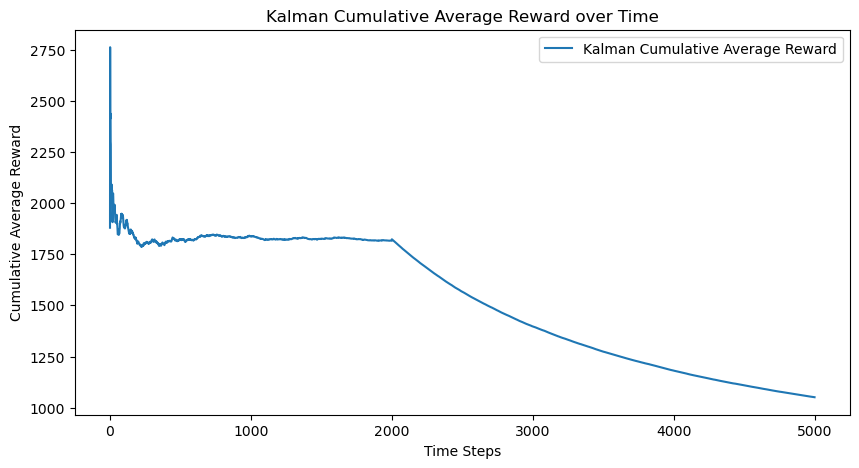

In [433]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#pivot_df = pd.read_csv('simulated_sensor_data.csv')
pivot_df = pd.read_csv('synthetic_dataset.csv')
#pivot_df = pd.read_csv('synthetic_dataset_two.csv')
#pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
#pivot_df = pd.read_csv('top_fifty_motes_humidity.csv')
#pivot_df = pivot_df.head(10000)

alpha = 15  # Set your desired alpha value
beta = 5  # Set your desired beta value

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance

theta = 0.5                             # Threshold for significant change
num_nodes_to_poll_list = [10]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    cumulative_reward = []

    def predict_node_state(x_hat, delta_t):
        A = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix
        return A @ x_hat

    def select_top_nodes(state_estimates, P, num_nodes_to_poll, currently_polled_nodes):
        covariance_traces = {mote: np.trace(P[mote]) for mote in state_estimates}
        sorted_motes_by_trace = sorted(covariance_traces, key=covariance_traces.get, reverse=True)
        top_nodes = set(sorted_motes_by_trace[:num_nodes_to_poll])
        return top_nodes 
        #return top_nodes | currently_polled_nodes 

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        top_sensors = select_top_nodes(state_estimates, P, num_nodes_to_poll, currently_polled_nodes)

        total_reward_for_round = 0
        for mote in top_sensors:
            polled_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            
            A = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix
            xp = A @ previous_state
            Pp = A @ previous_P @ A.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            # Corrected section
            last_value = last_sensed_values[mote]
            diff = abs(measured_value - last_value)*alpha
            weighted_time =  beta/delta_t
            R_s = diff* weighted_time

            if abs(measured_value - last_value) > theta:  # Add reward only if it exceeds the threshold
                total_reward_for_round += (R_s-2)
                transmitted_count[mote] += 1
                last_sensed_values[mote] = measured_value

                valuable_sensor_data.append({
                    'index': current_time_step,
                    'selected_moteid': mote,
                    'temperature': measured_value,
                    'predicted_temperature': x_hat[0, 0],  # Still keep the predicted temperature for analysis
                    'time_elapsed': delta_t
                })
            else :
                total_reward_for_round -= 2

            currently_polled_nodes.add(mote)
            last_update_times[mote] = current_time_step

        cumulative_reward.append(total_reward_for_round)

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, average_lifetime_years, cumulative_reward

results = {}
valuable_sensor_df_list = []
cumulative_rewards_kalman = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime, cumulative_reward = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    cumulative_rewards_kalman.append(cumulative_reward)
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")

# Save cumulative rewards for Kalman to CSV
pd.DataFrame(cumulative_rewards_kalman[0], columns=["cumulative_reward"]).to_csv('cumulative_rewards_kalman.csv', index=False)

# Calculate cumulative reward and cumulative average reward for Kalman
cumulative_reward_array_kalman = np.cumsum(cumulative_rewards_kalman[0])
cumulative_average_reward_kalman = cumulative_reward_array_kalman / (np.arange(len(cumulative_reward_array_kalman)) + 1)

# Plot cumulative average reward over time for Kalman
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward_kalman)), cumulative_average_reward_kalman, label='Kalman Cumulative Average Reward')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Average Reward')
plt.title('Kalman Cumulative Average Reward over Time')
plt.legend()
plt.show()


# Whittle index

Running Whittle simulation for 10 nodes to poll...
Completed Whittle simulation for 10 nodes to poll.


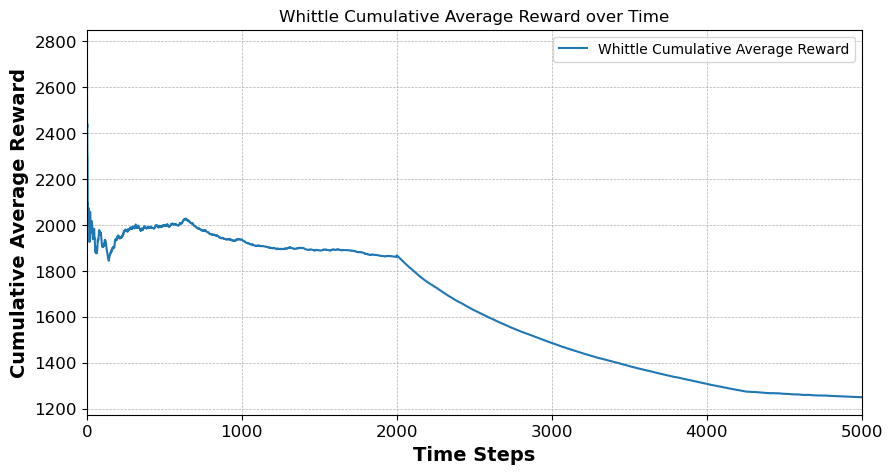

In [432]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

#pivot_df = pd.read_csv('simulated_sensor_data.csv')
pivot_df = pd.read_csv('synthetic_dataset.csv')
#pivot_df = pd.read_csv('synthetic_dataset_two.csv')
#pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
#pivot_df = pd.read_csv('top_fifty_motes_humidity.csv')
#pivot_df = pivot_df.head(10000)

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
theta = 0.5                           # Threshold for significant change (equal to m_i)
num_nodes_to_poll_list = [10]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
pdr = 0.9     
alpha = 15  # Set your desired alpha value
beta = 5                            # Probability of transmission failure

# WhittleArm class
class WhittleArm:
    def __init__(self, initial_value=0.):
        self.value_estimate = initial_value
        
    def update(self, value):
        
        self.value_estimate = value

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def calculate_q_value(mote, delta_t, predicted_value, current_value):
    """Calculate the Q-value for a given mote."""
    #return -theta  + ((delta_t) * abs(predicted_value - current_value)*2)
    return -2+(beta/delta_t) *  abs(predicted_value - current_value)*alpha

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    whittle_arms = {f'mote{i}': WhittleArm() for i in range(1, 51)}
    transmission_events_1 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1-1000
    transmission_events_2 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1000-2000
    previously_polled_nodes = set()
    cumulative_reward = []

    def predict_node_state(x_hat, delta_t):
        A_delta = get_state_transition_matrix(delta_t)
        return A_delta @ x_hat

    def select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes):
        expected_Q_value = {mote: 0 for mote in state_estimates}
        
        for mote in state_estimates:
            delta_t = (current_time_step - last_update_times[mote])
            if delta_t > 0:
                predicted_state = predict_node_state(state_estimates[mote], delta_t)
                predicted_value = H @ predicted_state
                current_value = last_sensed_values[mote]
                Q_value = calculate_q_value(mote, delta_t, predicted_value, current_value)
                if np.isnan(Q_value):
                    Q_value = 0
                expected_Q_value[mote] = Q_value
        
        for mote in expected_Q_value:
            whittle_arms[mote].update(expected_Q_value[mote])

        # Select top M nodes based on the highest value_estimate in whittle_arms
        nodes_by_whittle = sorted(whittle_arms.keys(), key=lambda mote: whittle_arms[mote].value_estimate, reverse=True)
        #top_m_nodes = nodes_by_whittle[:num_nodes_to_poll]
        nodes_to_poll = nodes_by_whittle[:num_nodes_to_poll]

        #nodes_to_poll = []
        """for mote in top_m_nodes:
            if expected_Q_value[mote] > theta:
                nodes_to_poll.append(mote)
        """
        
        return nodes_to_poll

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        nodes_to_poll = select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes)
        #nodes_to_poll = list(currently_polled_nodes) + nodes_to_poll

        total_reward_for_round = 0
        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat
            diff = abs(last_sensed_values[mote] - measured_value)*alpha
            A_R_s =  (beta/delta_t) * diff 
            if np.isnan(A_R_s):
                A_R_s = 0  # Replace NaN actual rewards with zero
            if abs(last_sensed_values[mote] - measured_value)  > theta:  # Add reward only if it exceeds the threshold
                total_reward_for_round += (A_R_s-2)
            else : 
                total_reward_for_round -= 2


            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'Temperature': measured_value,
                'predicted temperature': x_hat[0, 0],
                'time_elapsed': delta_t
            })

            if 0 <= current_time_step < 2000:
                transmission_events_1[mote].append(current_time_step)
            elif 2000 <= current_time_step < 5000:
                transmission_events_2[mote].append(current_time_step)

        cumulative_reward.append(total_reward_for_round)
        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step
            last_sensed_values[mote] = row[mote]

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    valuable_sensor_df['squared_error'] = (valuable_sensor_df['Temperature'] - valuable_sensor_df['predicted temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    return average_mse, cumulative_reward, valuable_sensor_df, transmission_events_1, transmission_events_2

results = {}
valuable_sensor_df_list = []
transmission_events_1_list = []
transmission_events_2_list = []
cumulative_rewards_whittle = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running Whittle simulation for {num_nodes_to_poll} nodes to poll...")
    mse, cumulative_reward, valuable_sensor_df, transmission_events_1, transmission_events_2 = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse}
    cumulative_rewards_whittle.append(cumulative_reward)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    transmission_events_1_list.append(transmission_events_1)
    transmission_events_2_list.append(transmission_events_2)
    print(f"Completed Whittle simulation for {num_nodes_to_poll} nodes to poll.")

# Save cumulative rewards for Whittle to CSV
pd.DataFrame(cumulative_rewards_whittle[0], columns=["cumulative_reward"]).to_csv('cumulative_rewards_whittle.csv', index=False)

# Calculate cumulative reward and cumulative average reward for Whittle
cumulative_reward_array_whittle = np.cumsum(cumulative_rewards_whittle[0])
cumulative_average_reward_whittle = cumulative_reward_array_whittle / (np.arange(len(cumulative_reward_array_whittle)) + 1)

# Plot cumulative average reward over time for Whittle
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward_whittle)), cumulative_average_reward_whittle, label='Whittle Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=14, fontweight='bold')
plt.title('Whittle Cumulative Average Reward over Time')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, len(pivot_df))  # Force x-axis to cover the entire length of the dataset
plt.show()

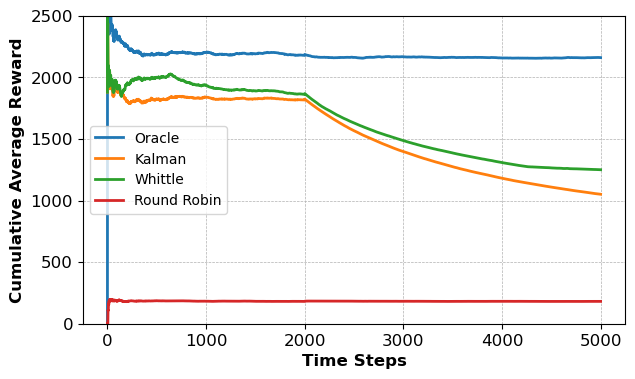

In [437]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load cumulative rewards from CSV files
cumulative_rewards_oracle = pd.read_csv('cumulative_rewards_oracle.csv')['cumulative_reward'].values
cumulative_rewards_ucb = pd.read_csv('cumulative_rewards_ucb.csv')['cumulative_reward'].values
cumulative_rewards_kalman = pd.read_csv('cumulative_rewards_kalman.csv')['cumulative_reward'].values
cumulative_rewards_whittle = pd.read_csv('cumulative_rewards_whittle.csv')['cumulative_reward'].values
cumulative_rewards_round_robin = pd.read_csv('cumulative_rewards_round_robin.csv')['cumulative_reward'].values

# Calculate cumulative average rewards
cumulative_average_reward_oracle = np.cumsum(cumulative_rewards_oracle) / (np.arange(len(cumulative_rewards_oracle)) + 1)
cumulative_average_reward_ucb = np.cumsum(cumulative_rewards_ucb) / (np.arange(len(cumulative_rewards_ucb)) + 1)
cumulative_average_reward_kalman = np.cumsum(cumulative_rewards_kalman) / (np.arange(len(cumulative_rewards_kalman)) + 1)
cumulative_average_reward_whittle = np.cumsum(cumulative_rewards_whittle) / (np.arange(len(cumulative_rewards_whittle)) + 1)
cumulative_average_reward_round_robin = np.cumsum(cumulative_rewards_round_robin) / (np.arange(len(cumulative_rewards_round_robin)) + 1)

# Plot cumulative average rewards over time for all techniques
# Plot cumulative average rewards over time for all techniques with M-limit from 0 to 1000
plt.figure(figsize=(7, 4))
plt.plot(range(len(cumulative_average_reward_oracle)), cumulative_average_reward_oracle, label='Oracle', linewidth=2)
#plt.plot(range(len(cumulative_average_reward_ucb)), cumulative_average_reward_ucb, label='UCB', linewidth=2)
plt.plot(range(len(cumulative_average_reward_kalman)), cumulative_average_reward_kalman, label='Kalman', linewidth=2)
plt.plot(range(len(cumulative_average_reward_whittle)), cumulative_average_reward_whittle, label='Whittle', linewidth=2)
plt.plot(range(len(cumulative_average_reward_round_robin)), cumulative_average_reward_round_robin, label='Round Robin', linewidth=2)
plt.xlabel('Time Steps', fontsize=12, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=12, fontweight='bold')
plt.ylim(0, 2500)  # Set the x-axis limit from 0 to 1000
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)

# Synthetic data 3

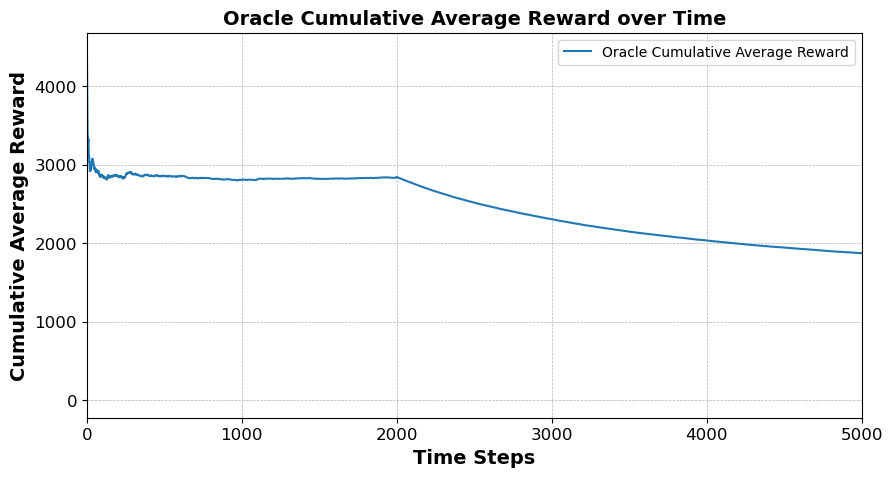

In [447]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#pivot_df = pd.read_csv('simulated_sensor_data.csv')
#pivot_df = pd.read_csv('synthetic_dataset.csv')
pivot_df = pd.read_csv('synthetic_dataset_two.csv')
#pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
#pivot_df = pd.read_csv('top_fifty_motes_humidity.csv')
#pivot_df = pivot_df.head(10000)

# Parameters
num_nodes_to_poll_list = [10]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled 
theta = 0.5                           # Threshold for significant change
alpha = 15    # Set your desired alpha value
beta = 5   # Set your desired beta value

# Initialize last polled values with an assumed initial estimate of 20
last_polled_values = {f'mote{i}': 20 for i in range(1, 51)}

def run_oracle_simulation(num_nodes_to_poll):
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    cumulative_reward = []
    valuable_sensor_data = []

    for idx in range(len(pivot_df)):  # Loop over each time step
        current_time_step = idx
        rewards = {}

        for mote in last_update_times:
            delta_t = (current_time_step - last_update_times[mote])
            if delta_t > 0:
                current_value = pivot_df.loc[current_time_step, mote]
                last_value = last_polled_values[mote]  # Retrieve the last polled value (initially set to 20)

                # Calculate magnitude change and AoII
                magnitude_change = abs(current_value - last_value) * alpha
                weighted_time =   beta/delta_t
                AoII = magnitude_change * weighted_time
                rewards[mote] = AoII

        # Sort nodes by AoII and select top M nodes with rewards greater than theta
        top_m_nodes = [mote for mote in sorted(rewards, key=rewards.get, reverse=True) if rewards[mote] > theta][:num_nodes_to_poll]
        #top_m_nodes = sorted(rewards, key=rewards.get, reverse=True)[:num_nodes_to_poll]
        total_reward_for_round = 0

        for mote in top_m_nodes:
            measured_value = pivot_df.loc[current_time_step, mote]
            delta_t = (current_time_step - last_update_times[mote])

            # Recalculate AoII for the selected nodes
            magnitude_change = abs(measured_value - last_polled_values[mote]) * alpha
            weighted_time =   beta/delta_t
            AoII = magnitude_change * weighted_time

            if np.isnan(AoII):
                AoII = 0  # Replace NaN rewards with zero
            if abs(measured_value - last_polled_values[mote]) > theta:
                total_reward_for_round += (AoII-2)
            else:
                total_reward_for_round -= 2 # Penalty for unnecessary polling

            # Update last polled value and time
            last_update_times[mote] = current_time_step
            last_polled_values[mote] = measured_value  # Update with the new polled value

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': measured_value,  # Oracle knows the true value
                'time_elapsed': delta_t
            })

        cumulative_reward.append(total_reward_for_round)

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    return cumulative_reward, valuable_sensor_df

results_oracle = {}
cumulative_rewards_oracle = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    cumulative_reward, valuable_sensor_df = run_oracle_simulation(num_nodes_to_poll)
    cumulative_rewards_oracle.append(cumulative_reward)

# Save cumulative rewards for Oracle to CSV
pd.DataFrame(cumulative_rewards_oracle[0], columns=["cumulative_reward"]).to_csv('cumulative_rewards_oracle.csv', index=False)

# Calculate cumulative reward and cumulative average reward for Oracle
cumulative_reward_array_oracle = np.cumsum(cumulative_rewards_oracle[0])
cumulative_average_reward_oracle = cumulative_reward_array_oracle / (np.arange(len(cumulative_reward_array_oracle)) + 1)

# Check for NaN or inf values
nan_indices = np.where(np.isnan(cumulative_reward_array_oracle))[0]
inf_indices = np.where(np.isinf(cumulative_reward_array_oracle))[0]

# Plot cumulative average reward over time for Oracle
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward_oracle)), cumulative_average_reward_oracle, label='Oracle Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=14, fontweight='bold')
plt.title('Oracle Cumulative Average Reward over Time', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, len(pivot_df))  # Force x-axis to cover the entire length of the dataset

# Save the plot
plt.savefig('oracle_cumulative_average_reward.png')

plt.show()

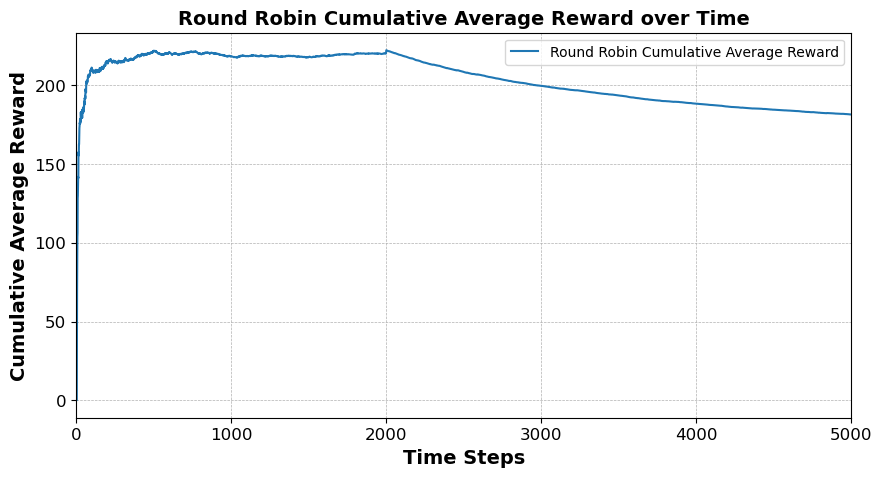

In [448]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#pivot_df = pd.read_csv('simulated_sensor_data.csv')
#pivot_df = pd.read_csv('synthetic_dataset.csv')
pivot_df = pd.read_csv('synthetic_dataset_two.csv')
#pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
#pivot_df = pd.read_csv('top_fifty_motes_humidity.csv')
#pivot_df = pivot_df.head(10000)

alpha = 15  # Set your desired alpha value
beta = 5   # Set your desired beta value

# Extract the list of nodes (column names excluding the 'SN' column)
nodes = [col for col in pivot_df.columns if col != 'SN']
total_nodes = len(nodes)  # Total number of nodes
num_pulls_per_round = 10  # Number of nodes to pull in each round
interval = total_nodes // num_pulls_per_round  # Time interval between pulls of the same node
theta = 0.5  # Threshold for significant reward

# Initialize variables
last_measured_values = {node: None for node in nodes}
last_update_times = {node: -interval for node in nodes}
cumulative_reward = []
valuable_sensor_data = []

def run_round_robin_simulation():
    current_round = 0
    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        node_start = (current_round * num_pulls_per_round) % total_nodes
        nodes_to_poll = nodes[node_start:node_start + num_pulls_per_round]

        total_reward_for_round = 0
        for node in nodes_to_poll:
            measured_value = row[node]
            delta_t = (current_time_step - last_update_times[node])

            weighted_time =  beta/delta_t 

            if last_measured_values[node] is not None:
                
                magnitude_change = abs(measured_value - last_measured_values[node])*alpha
                AoII = magnitude_change * weighted_time
                if abs(measured_value - last_measured_values[node]) > theta:
                    total_reward_for_round += (AoII-2)

                else : 
                    total_reward_for_round -= 2

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_node': node,
                'temperature': measured_value,
                'time_elapsed': delta_t
            })

            last_update_times[node] = current_time_step
            last_measured_values[node] = measured_value

        cumulative_reward.append(total_reward_for_round)
        current_round += 1

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    return cumulative_reward, valuable_sensor_df

# Run the round-robin simulation and collect rewards
round_robin_rewards, valuable_sensor_df = run_round_robin_simulation()

# Save cumulative rewards for round-robin to CSV
pd.DataFrame(round_robin_rewards, columns=["cumulative_reward"]).to_csv('cumulative_rewards_round_robin.csv', index=False)

# Calculate cumulative reward and cumulative average reward for round-robin
cumulative_reward_array = np.cumsum(round_robin_rewards)
cumulative_average_reward = cumulative_reward_array / (np.arange(len(cumulative_reward_array)) + 1)

# Plot cumulative average reward over time
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward)), cumulative_average_reward, label='Round Robin Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=14, fontweight='bold')
plt.title('Round Robin Cumulative Average Reward over Time', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, len(pivot_df))  # Force x-axis to cover the entire length of the dataset

# Save the plot
plt.savefig('round_robin_cumulative_average_reward.png')

plt.show()

Running simulation for 10 nodes to poll...
Completed simulation for 10 nodes to poll.
Nodes to poll: 10
  Average MSE: 3.470575373572549
  Average sensor lifetime (years): 0.3267062005824517


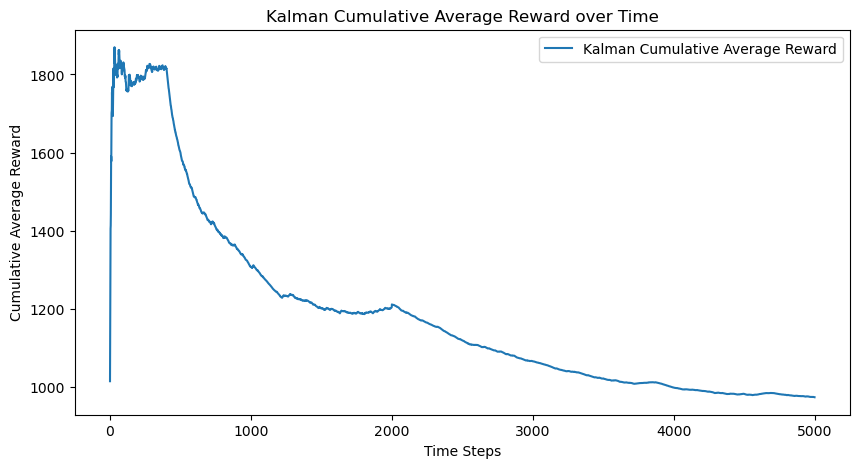

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


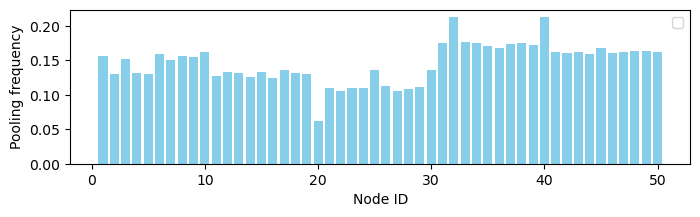

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#pivot_df = pd.read_csv('simulated_sensor_data.csv')
#pivot_df = pd.read_csv('synthetic_dataset.csv')
pivot_df = pd.read_csv('synthetic_dataset_two.csv')
#pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
#pivot_df = pd.read_csv('top_fifty_motes_humidity.csv')
#pivot_df = pivot_df.head(10000)

alpha = 15  # Set your desired alpha value
beta = 5  # Set your desired beta value

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance

theta = 0.5                             # Threshold for significant change
num_nodes_to_poll_list = [10]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    cumulative_reward = []

    def predict_node_state(x_hat, delta_t):
        A = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix
        return A @ x_hat

    def select_top_nodes(state_estimates, P, num_nodes_to_poll, currently_polled_nodes):
        covariance_traces = {mote: np.trace(P[mote]) for mote in state_estimates}
        sorted_motes_by_trace = sorted(covariance_traces, key=covariance_traces.get, reverse=True)
        top_nodes = set(sorted_motes_by_trace[:num_nodes_to_poll])
        #return top_nodes 
        return top_nodes | currently_polled_nodes 

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        top_sensors = select_top_nodes(state_estimates, P, num_nodes_to_poll, currently_polled_nodes)

        total_reward_for_round = 0
        for mote in top_sensors:
            polled_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            
            A = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix
            xp = A @ previous_state
            Pp = A @ previous_P @ A.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            # Corrected section
            last_value = last_sensed_values[mote]
            diff = abs(measured_value - last_value)*alpha
            weighted_time =  beta/delta_t
            R_s = diff* weighted_time

            if abs(measured_value - last_value) > theta:  # Add reward only if it exceeds the threshold
                total_reward_for_round += (R_s-2)
                transmitted_count[mote] += 1
                last_sensed_values[mote] = measured_value

                valuable_sensor_data.append({
                    'index': current_time_step,
                    'selected_moteid': mote,
                    'temperature': measured_value,
                    'predicted_temperature': x_hat[0, 0],  # Still keep the predicted temperature for analysis
                    'time_elapsed': delta_t
                })
            else :
                total_reward_for_round -= 2

            currently_polled_nodes.add(mote)
            last_update_times[mote] = current_time_step

        cumulative_reward.append(total_reward_for_round)

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, transmitted_count, average_lifetime_years, cumulative_reward

results = {}
valuable_sensor_df_list = []
cumulative_rewards_kalman = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, transmitted_count, lifetime, cumulative_reward = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    cumulative_rewards_kalman.append(cumulative_reward)
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")

# Save cumulative rewards for Kalman to CSV
pd.DataFrame(cumulative_rewards_kalman[0], columns=["cumulative_reward"]).to_csv('cumulative_rewards_kalman.csv', index=False)

# Calculate cumulative reward and cumulative average reward for Kalman
cumulative_reward_array_kalman = np.cumsum(cumulative_rewards_kalman[0])
cumulative_average_reward_kalman = cumulative_reward_array_kalman / (np.arange(len(cumulative_reward_array_kalman)) + 1)

# Plot cumulative average reward over time for Kalman
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward_kalman)), cumulative_average_reward_kalman, label='Kalman Cumulative Average Reward')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Average Reward')
plt.title('Kalman Cumulative Average Reward over Time')
plt.legend()
plt.show()

total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Node ID')
plt.ylabel('Pooling frequency')
plt.legend()

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks)

# Save the plot
plt.savefig('kalman_pooling_frequency.png')
plt.show()


Running Whittle simulation for 10 nodes to poll...
Completed Whittle simulation for 10 nodes to poll.


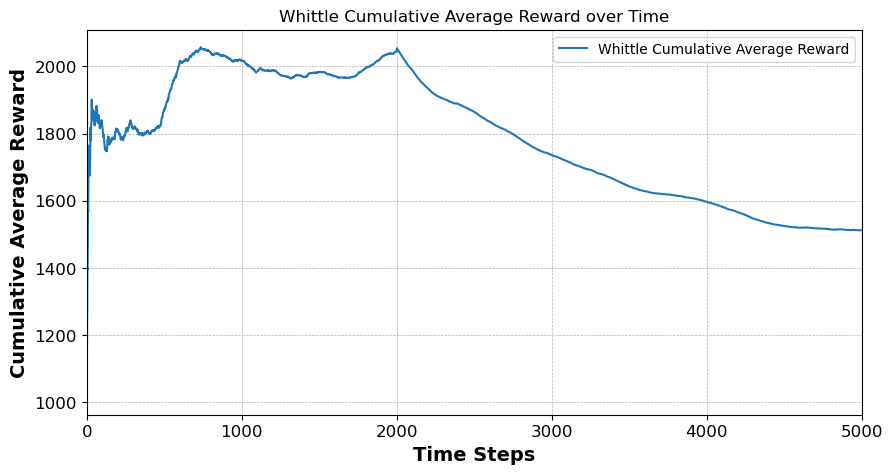

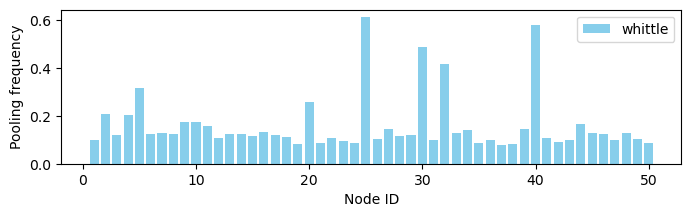

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

#pivot_df = pd.read_csv('simulated_sensor_data.csv')
#pivot_df = pd.read_csv('synthetic_dataset.csv')
pivot_df = pd.read_csv('synthetic_dataset_two.csv')
#pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
#pivot_df = pd.read_csv('top_fifty_motes_humidity.csv')
#pivot_df = pivot_df.head(10000)

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
theta = 0.5                           # Threshold for significant change (equal to m_i)
num_nodes_to_poll_list = [10]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
pdr = 0.9     
alpha = 15                            # Set your desired alpha value
beta = 5                              # Probability of transmission failure

# WhittleArm class
class WhittleArm:
    def __init__(self, initial_value=0.):
        self.value_estimate = initial_value
        
    def update(self, value):
        
        self.value_estimate = value

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def calculate_q_value(mote, delta_t, predicted_value, current_value):
    """Calculate the Q-value for a given mote."""
    #return -theta  + ((delta_t) * abs(predicted_value - current_value)*2)
    return -2+(beta/delta_t) *  abs(predicted_value - current_value)*alpha

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    whittle_arms = {f'mote{i}': WhittleArm() for i in range(1, 51)}
    transmission_events_1 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1-1000
    transmission_events_2 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1000-2000
    previously_polled_nodes = set()
    cumulative_reward = []

    def predict_node_state(x_hat, delta_t):
        A_delta = get_state_transition_matrix(delta_t)
        return A_delta @ x_hat

    def select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes):
        expected_Q_value = {mote: 0 for mote in state_estimates}
        
        for mote in state_estimates:
            delta_t = (current_time_step - last_update_times[mote])
            if delta_t > 0:
                predicted_state = predict_node_state(state_estimates[mote], delta_t)
                predicted_value = H @ predicted_state
                current_value = last_sensed_values[mote]
                Q_value = calculate_q_value(mote, delta_t, predicted_value, current_value)
                if np.isnan(Q_value):
                    Q_value = 0
                expected_Q_value[mote] = Q_value
        
        for mote in expected_Q_value:
            whittle_arms[mote].update(expected_Q_value[mote])

        # Select top M nodes based on the highest value_estimate in whittle_arms
        nodes_by_whittle = sorted(whittle_arms.keys(), key=lambda mote: whittle_arms[mote].value_estimate, reverse=True)
        #top_m_nodes = nodes_by_whittle[:num_nodes_to_poll]
        nodes_to_poll = nodes_by_whittle[:num_nodes_to_poll]

        #nodes_to_poll = []
        """for mote in top_m_nodes:
            if expected_Q_value[mote] > theta:
                nodes_to_poll.append(mote)
        """
        
        return nodes_to_poll

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        nodes_to_poll = select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes)
        nodes_to_poll = list(currently_polled_nodes) + nodes_to_poll

        total_reward_for_round = 0
        for mote in nodes_to_poll:
            polled_count[mote] += 1
            
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat
            diff = abs(last_sensed_values[mote] - measured_value)*alpha
            A_R_s =  (beta/delta_t) * diff 
            if np.isnan(A_R_s):
                A_R_s = 0  # Replace NaN actual rewards with zero
            if abs(last_sensed_values[mote] - measured_value)  > theta:  # Add reward only if it exceeds the threshold
                total_reward_for_round += (A_R_s-2)
                transmitted_count[mote] += 1
            else : 
                total_reward_for_round -= 2


            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'Temperature': measured_value,
                'predicted temperature': x_hat[0, 0],
                'time_elapsed': delta_t
            })

            if 0 <= current_time_step < 2000:
                transmission_events_1[mote].append(current_time_step)
            elif 2000 <= current_time_step < 5000:
                transmission_events_2[mote].append(current_time_step)

        cumulative_reward.append(total_reward_for_round)
        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step
            last_sensed_values[mote] = row[mote]

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    valuable_sensor_df['squared_error'] = (valuable_sensor_df['Temperature'] - valuable_sensor_df['predicted temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    return average_mse, transmitted_count, cumulative_reward, valuable_sensor_df, transmission_events_1, transmission_events_2

results = {}
valuable_sensor_df_list = []
transmission_events_1_list = []
transmission_events_2_list = []
cumulative_rewards_whittle = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running Whittle simulation for {num_nodes_to_poll} nodes to poll...")
    mse,transmitted_count, cumulative_reward, valuable_sensor_df, transmission_events_1, transmission_events_2 = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse}
    cumulative_rewards_whittle.append(cumulative_reward)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    transmission_events_1_list.append(transmission_events_1)
    transmission_events_2_list.append(transmission_events_2)
    print(f"Completed Whittle simulation for {num_nodes_to_poll} nodes to poll.")

# Save cumulative rewards for Whittle to CSV
pd.DataFrame(cumulative_rewards_whittle[0], columns=["cumulative_reward"]).to_csv('cumulative_rewards_whittle.csv', index=False)

# Calculate cumulative reward and cumulative average reward for Whittle
cumulative_reward_array_whittle = np.cumsum(cumulative_rewards_whittle[0])
cumulative_average_reward_whittle = cumulative_reward_array_whittle / (np.arange(len(cumulative_reward_array_whittle)) + 1)

# Plot cumulative average reward over time for Whittle
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward_whittle)), cumulative_average_reward_whittle, label='Whittle Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=14, fontweight='bold')
plt.title('Whittle Cumulative Average Reward over Time')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, len(pivot_df))  # Force x-axis to cover the entire length of the dataset
plt.show()

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue', label='whittle')
plt.xlabel('Node ID')
plt.ylabel('Pooling frequency')
plt.legend()

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks)

# Save the plot
plt.savefig('whittle_pooling_frequency.png')
plt.show()

# Whittle AoI 

Running Whittle simulation for 10 nodes to poll...
Completed Whittle_AoI simulation for 10 nodes to poll.


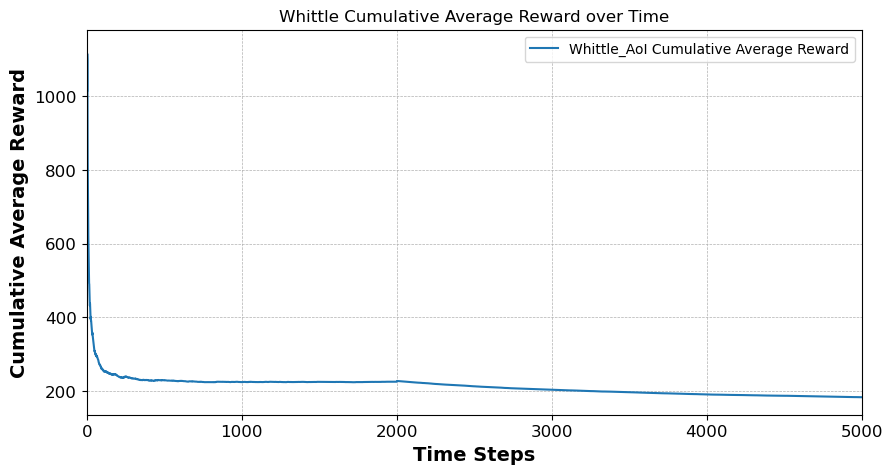

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


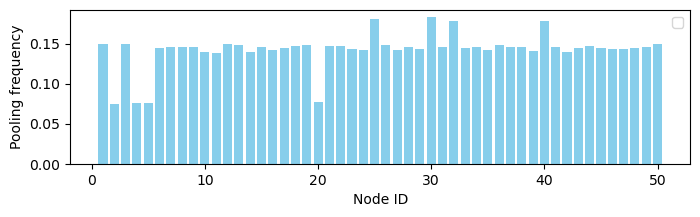

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

#pivot_df = pd.read_csv('simulated_sensor_data.csv')
#pivot_df = pd.read_csv('synthetic_dataset.csv')
pivot_df = pd.read_csv('synthetic_dataset_two.csv')
#pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
#pivot_df = pd.read_csv('top_fifty_motes_humidity.csv')
#pivot_df = pivot_df.head(10000)

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
theta = 0.5                           # Threshold for significant change (equal to m_i)
num_nodes_to_poll_list = [10]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
pdr = 0.9     
alpha = 15  # Set your desired alpha value
beta = 5                            # Probability of transmission failure

# WhittleArm class
class WhittleArm_AoI:
    def __init__(self, initial_value=0.):
        self.value_estimate = initial_value
        
    def update(self, value):
        
        self.value_estimate = value

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def calculate_q_value(mote, delta_t, predicted_value, current_value):
    """Calculate the Q-value for a given mote."""
    #return -theta  + ((delta_t) * abs(predicted_value - current_value)*2)
    return (delta_t) 

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    whittle_arms = {f'mote{i}': WhittleArm_AoI() for i in range(1, 51)}
    transmission_events_1 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1-1000
    transmission_events_2 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1000-2000
    previously_polled_nodes = set()
    cumulative_reward = []

    def predict_node_state(x_hat, delta_t):
        A_delta = get_state_transition_matrix(delta_t)
        return A_delta @ x_hat

    def select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes):
        expected_Q_value = {mote: 0 for mote in state_estimates}
        
        for mote in state_estimates:
            delta_t = (current_time_step - last_update_times[mote])
            if delta_t > 0:
                predicted_state = predict_node_state(state_estimates[mote], delta_t)
                predicted_value = H @ predicted_state
                current_value = last_sensed_values[mote]
                Q_value = calculate_q_value(mote, delta_t, predicted_value, current_value)
                if np.isnan(Q_value):
                    Q_value = 0
                expected_Q_value[mote] = Q_value
        
        for mote in expected_Q_value:
            whittle_arms[mote].update(expected_Q_value[mote])

        # Select top M nodes based on the highest value_estimate in whittle_arms
        nodes_by_whittle = sorted(whittle_arms.keys(), key=lambda mote: whittle_arms[mote].value_estimate, reverse=True)
        #top_m_nodes = nodes_by_whittle[:num_nodes_to_poll]
        nodes_to_poll = nodes_by_whittle[:num_nodes_to_poll]

        #nodes_to_poll = []
        """for mote in top_m_nodes:
            if expected_Q_value[mote] > theta:
                nodes_to_poll.append(mote)
        """
        
        return nodes_to_poll

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        nodes_to_poll = select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes)
        nodes_to_poll = list(currently_polled_nodes) + nodes_to_poll

        total_reward_for_round = 0
        for mote in nodes_to_poll:
            polled_count[mote] += 1
            
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat
            diff = abs(last_sensed_values[mote] - measured_value)*alpha
            A_R_s =  (beta/delta_t) * diff 
            if np.isnan(A_R_s):
                A_R_s = 0  # Replace NaN actual rewards with zero
            if abs(last_sensed_values[mote] - measured_value)  > theta:  # Add reward only if it exceeds the threshold
                total_reward_for_round += (A_R_s-2)
                transmitted_count[mote] += 1
            else : 
                total_reward_for_round -= 2


            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'Temperature': measured_value,
                'predicted temperature': x_hat[0, 0],
                'time_elapsed': delta_t
            })

            if 0 <= current_time_step < 2000:
                transmission_events_1[mote].append(current_time_step)
            elif 2000 <= current_time_step < 5000:
                transmission_events_2[mote].append(current_time_step)

        cumulative_reward.append(total_reward_for_round)
        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step
            last_sensed_values[mote] = row[mote]

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    valuable_sensor_df['squared_error'] = (valuable_sensor_df['Temperature'] - valuable_sensor_df['predicted temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    return average_mse, transmitted_count, cumulative_reward, valuable_sensor_df, transmission_events_1, transmission_events_2

results = {}
valuable_sensor_df_list = []
transmission_events_1_list = []
transmission_events_2_list = []
cumulative_rewards_whittle = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running Whittle simulation for {num_nodes_to_poll} nodes to poll...")
    mse,transmitted_count, cumulative_reward, valuable_sensor_df, transmission_events_1, transmission_events_2 = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse}
    cumulative_rewards_whittle.append(cumulative_reward)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    transmission_events_1_list.append(transmission_events_1)
    transmission_events_2_list.append(transmission_events_2)
    print(f"Completed Whittle_AoI simulation for {num_nodes_to_poll} nodes to poll.")

# Save cumulative rewards for Whittle to CSV
pd.DataFrame(cumulative_rewards_whittle[0], columns=["cumulative_reward"]).to_csv('cumulative_rewards_whittle_AoI.csv', index=False)

# Calculate cumulative reward and cumulative average reward for Whittle
cumulative_reward_array_whittle = np.cumsum(cumulative_rewards_whittle[0])
cumulative_average_reward_whittle = cumulative_reward_array_whittle / (np.arange(len(cumulative_reward_array_whittle)) + 1)

# Plot cumulative average reward over time for Whittle
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward_whittle)), cumulative_average_reward_whittle, label='Whittle_AoI Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=14, fontweight='bold')
plt.title('Whittle Cumulative Average Reward over Time')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, len(pivot_df))  # Force x-axis to cover the entire length of the dataset
plt.show()

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(8, 2))
#plt.bar(ratios.keys(), ratios.values(), color='skyblue', label='whittle_AoI')
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Node ID')
plt.ylabel('Pooling frequency')
plt.legend()

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks)

# Save the plot
plt.savefig('whittle_aoi_pooling_frequency.png')
plt.show()

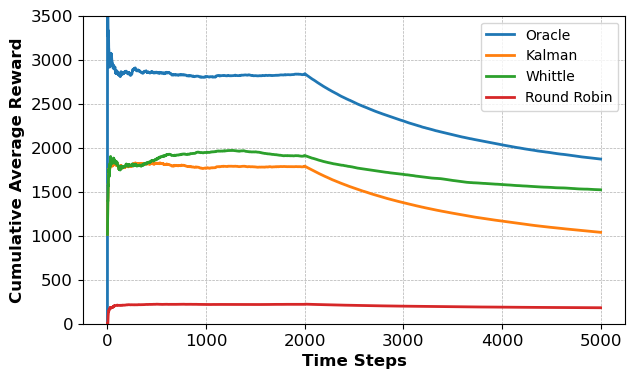

In [452]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load cumulative rewards from CSV files
cumulative_rewards_oracle = pd.read_csv('cumulative_rewards_oracle.csv')['cumulative_reward'].values
cumulative_rewards_ucb = pd.read_csv('cumulative_rewards_ucb.csv')['cumulative_reward'].values
cumulative_rewards_kalman = pd.read_csv('cumulative_rewards_kalman.csv')['cumulative_reward'].values
cumulative_rewards_whittle = pd.read_csv('cumulative_rewards_whittle.csv')['cumulative_reward'].values
cumulative_rewards_round_robin = pd.read_csv('cumulative_rewards_round_robin.csv')['cumulative_reward'].values

# Calculate cumulative average rewards
cumulative_average_reward_oracle = np.cumsum(cumulative_rewards_oracle) / (np.arange(len(cumulative_rewards_oracle)) + 1)
cumulative_average_reward_ucb = np.cumsum(cumulative_rewards_ucb) / (np.arange(len(cumulative_rewards_ucb)) + 1)
cumulative_average_reward_kalman = np.cumsum(cumulative_rewards_kalman) / (np.arange(len(cumulative_rewards_kalman)) + 1)
cumulative_average_reward_whittle = np.cumsum(cumulative_rewards_whittle) / (np.arange(len(cumulative_rewards_whittle)) + 1)
cumulative_average_reward_round_robin = np.cumsum(cumulative_rewards_round_robin) / (np.arange(len(cumulative_rewards_round_robin)) + 1)

# Plot cumulative average rewards over time for all techniques
# Plot cumulative average rewards over time for all techniques with M-limit from 0 to 1000
plt.figure(figsize=(7, 4))
plt.plot(range(len(cumulative_average_reward_oracle)), cumulative_average_reward_oracle, label='Oracle', linewidth=2)
#plt.plot(range(len(cumulative_average_reward_ucb)), cumulative_average_reward_ucb, label='UCB', linewidth=2)
plt.plot(range(len(cumulative_average_reward_kalman)), cumulative_average_reward_kalman, label='Kalman', linewidth=2)
plt.plot(range(len(cumulative_average_reward_whittle)), cumulative_average_reward_whittle, label='Whittle', linewidth=2)
plt.plot(range(len(cumulative_average_reward_round_robin)), cumulative_average_reward_round_robin, label='Round Robin', linewidth=2)
plt.xlabel('Time Steps', fontsize=12, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=12, fontweight='bold')
plt.ylim(0, 3500)  # Set the x-axis limit from 0 to 1000
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)

# Actual temp

# Actual humidity